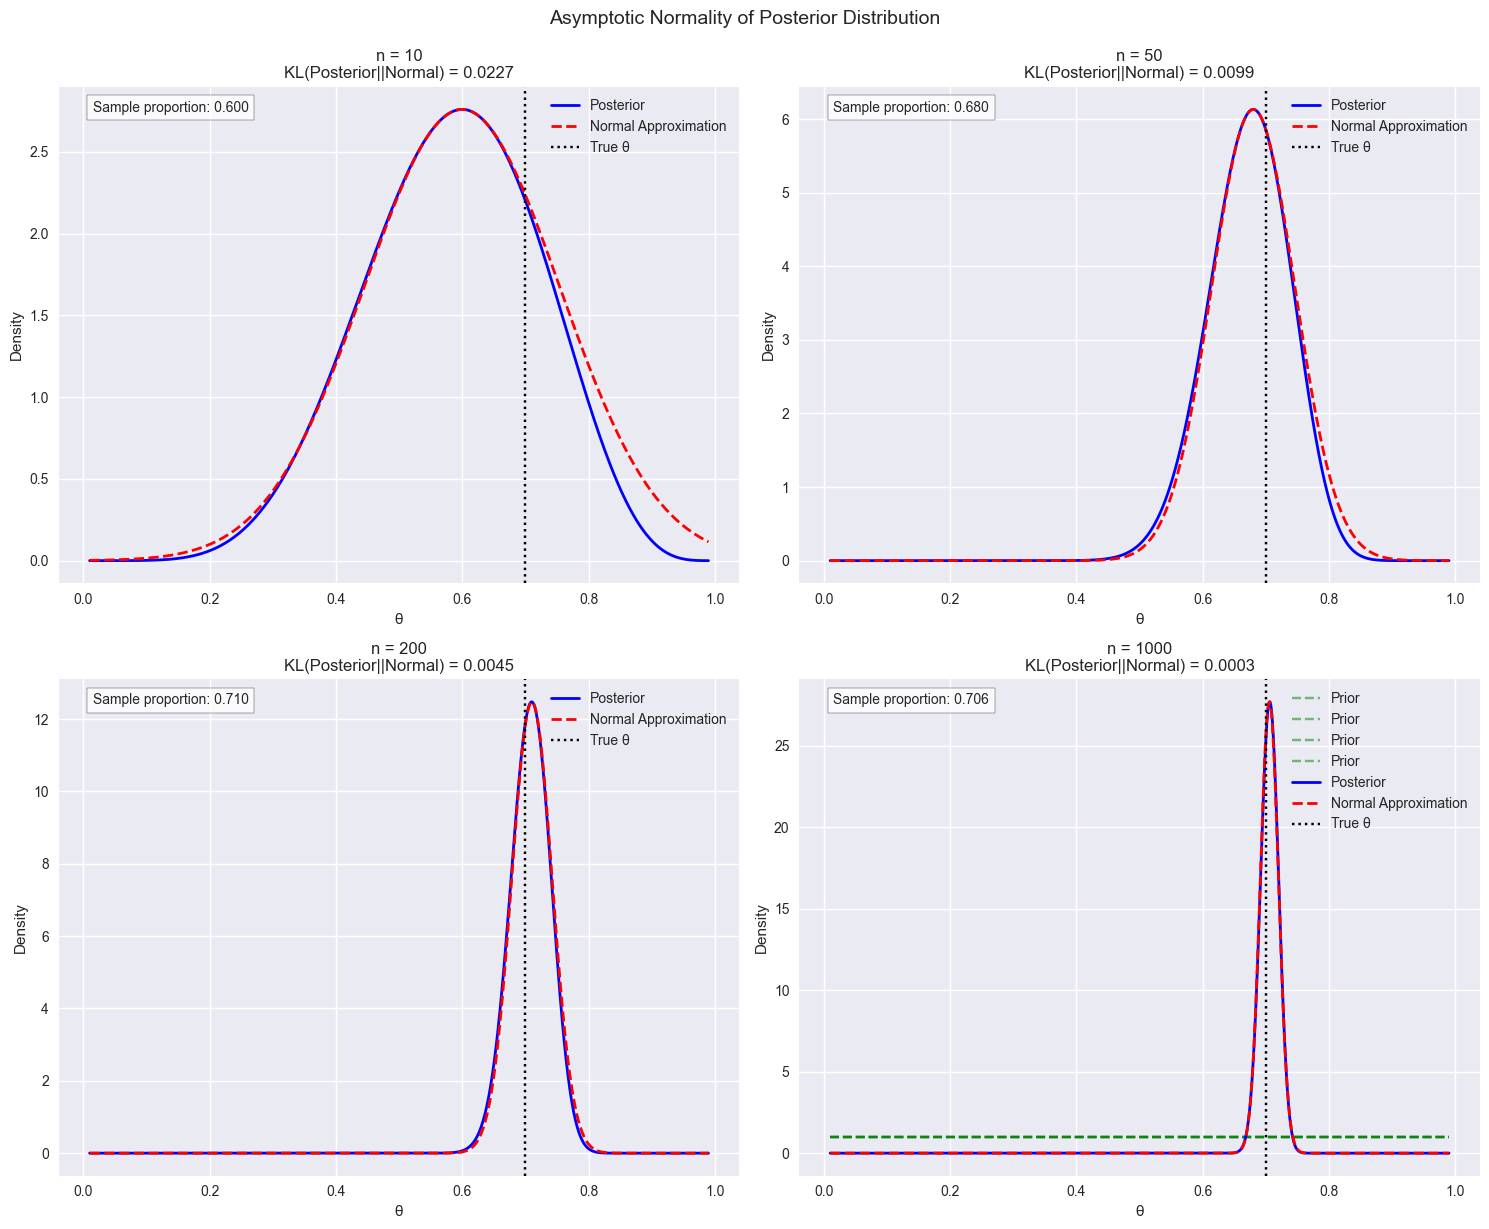

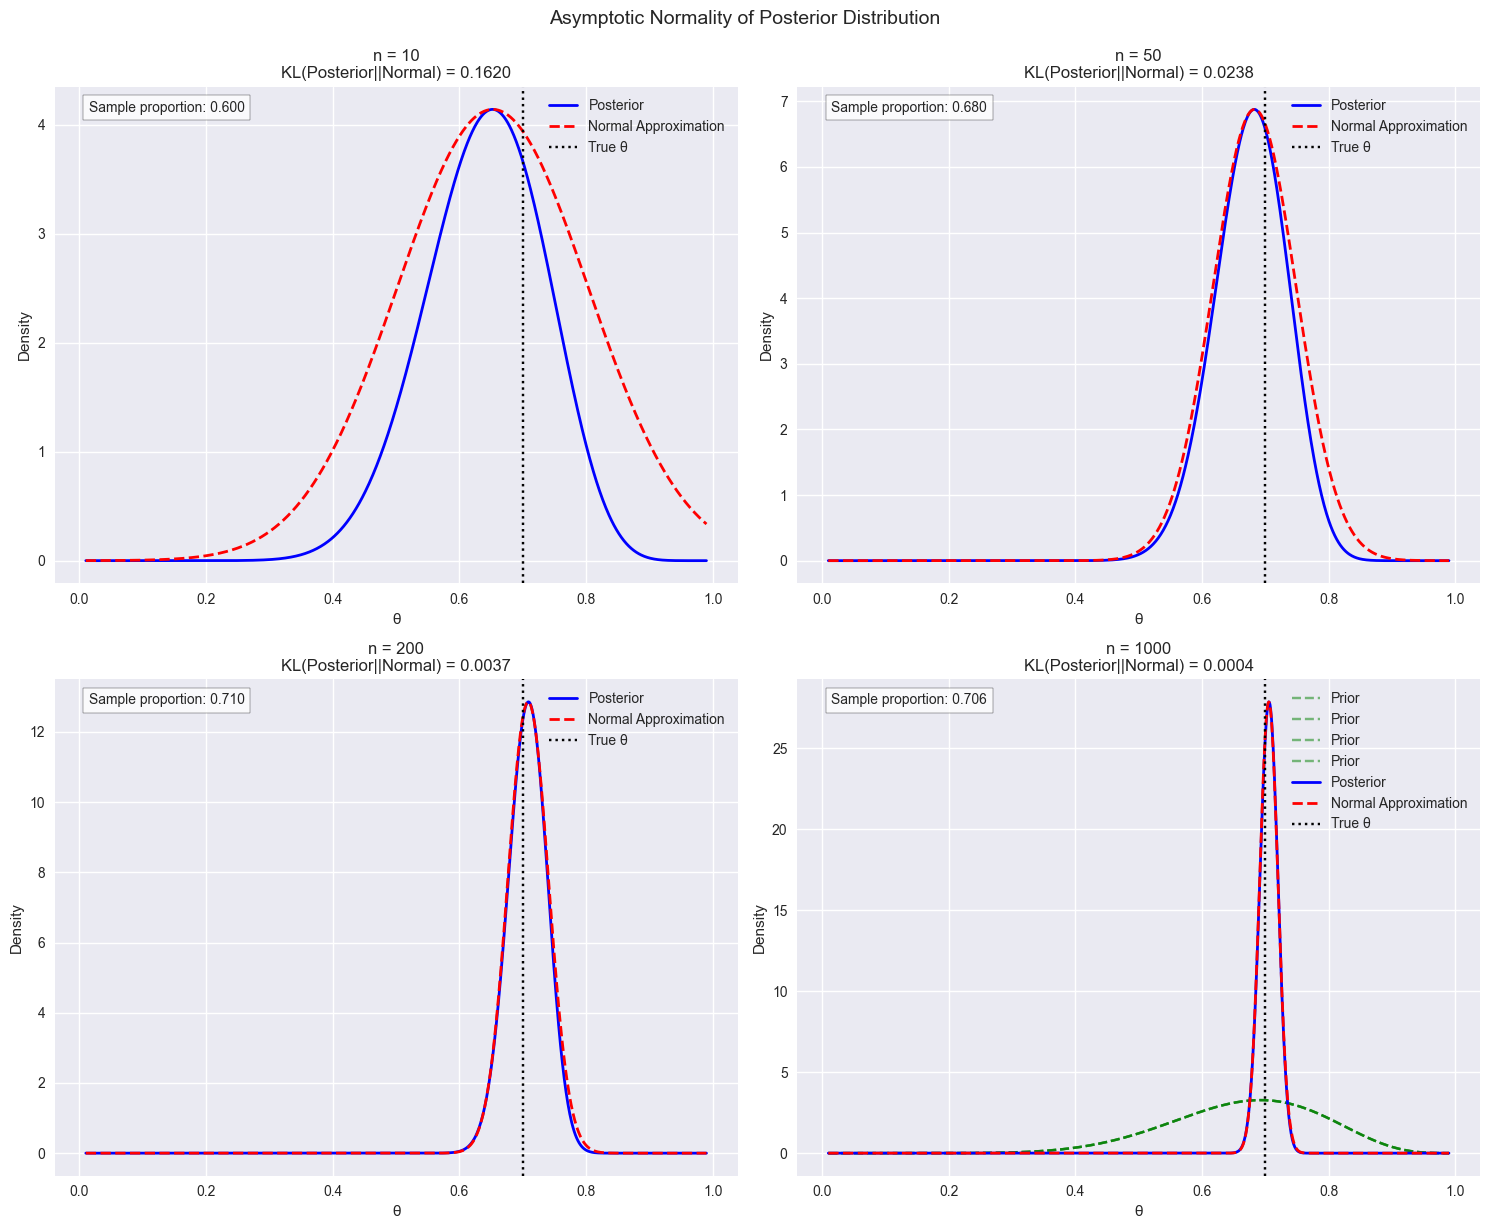

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

class BayesianAsymptoticDemo:
    """
    A class to demonstrate asymptotic normality of posterior distributions
    through interactive visualizations and educational examples.
    """
    
    def __init__(self, true_theta=0.7, prior_alpha=1, prior_beta=1):
        """
        Initialize the demonstration with chosen parameters.
        
        Parameters:
        -----------
        true_theta : float
            True parameter value (probability of success)
        prior_alpha : float
            Alpha parameter of Beta prior
        prior_beta : float
            Beta parameter of Beta prior
        """
        self.true_theta = true_theta
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta
        
        # Set up attractive plotting style
        plt.style.use('seaborn-v0_8')
        
    def plot_prior(self, theta_grid):
        """Visualize the prior distribution"""
        prior = stats.beta.pdf(theta_grid, self.prior_alpha, self.prior_beta)
        plt.plot(theta_grid, prior, 'g--', label='Prior', alpha=0.5)
        
    def compute_posterior(self, data, theta_grid):
        """
        Compute the posterior distribution given data.
        
        Parameters:
        -----------
        data : array-like
            Binary observations (0s and 1s)
        theta_grid : array-like
            Grid of theta values for evaluation
            
        Returns:
        --------
        posterior : array-like
            Posterior density values
        theta_mode : float
            Posterior mode
        """
        # Compute log posterior (unnormalized)
        log_posterior = (
            (data.sum() + self.prior_alpha - 1) * np.log(theta_grid) +
            (len(data) - data.sum() + self.prior_beta - 1) * np.log(1 - theta_grid)
        )
        
        # Normalize to get posterior
        posterior = np.exp(log_posterior - np.max(log_posterior))
        posterior = posterior / np.trapz(posterior, theta_grid)
        
        # Find mode
        theta_mode = theta_grid[np.argmax(posterior)]
        
        return posterior, theta_mode
    
    def demonstrate_convergence(self, n_samples_list=[10, 50, 200, 1000]):
        """
        Demonstrate how the posterior becomes increasingly normal with larger samples.
        
        Parameters:
        -----------
        n_samples_list : list
            List of sample sizes to demonstrate
        """
        # Create subplots for different sample sizes
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        theta_grid = np.linspace(0.01, 0.99, 1000)
        
        for idx, n in enumerate(n_samples_list):
            # Generate data
            np.random.seed(42 + idx)  # For reproducibility
            data = np.random.binomial(1, self.true_theta, size=n)
            
            # Compute posterior
            posterior, theta_mode = self.compute_posterior(data, theta_grid)
            
            # Compute observed information
            J_obs = n / (theta_mode * (1 - theta_mode))
            
            # Normal approximation
            normal_approx = stats.norm.pdf(theta_grid, theta_mode, 1/np.sqrt(J_obs))
            normal_approx = normal_approx / np.max(normal_approx) * np.max(posterior)
            
            # Plot everything
            ax = axes[idx]
            
            # Plot distributions
            self.plot_prior(theta_grid)
            ax.plot(theta_grid, posterior, 'b-', label='Posterior', linewidth=2)
            ax.plot(theta_grid, normal_approx, 'r--', 
                   label='Normal Approximation', linewidth=2)
            ax.axvline(self.true_theta, color='k', linestyle=':', label='True θ')
            
            # Add KL divergence from normal approximation
            kl_div = self.compute_kl_divergence(posterior, normal_approx, theta_grid)
            
            # Customize plot
            ax.set_title(f'n = {n}\nKL(Posterior||Normal) = {kl_div:.4f}')
            ax.set_xlabel('θ')
            ax.set_ylabel('Density')
            ax.legend()
            
            # Add annotations
            ax.annotate(
                f'Sample proportion: {data.mean():.3f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(facecolor='white', alpha=0.8)
            )
        
        plt.tight_layout()
        plt.suptitle('Asymptotic Normality of Posterior Distribution', 
                    y=1.02, fontsize=14)
        plt.show()
        
    def compute_kl_divergence(self, p, q, theta_grid):
        """Compute KL divergence between distributions p and q"""
        # Add small constant to avoid log(0)
        eps = 1e-10
        p = p + eps
        q = q + eps
        
        # Normalize
        p = p / np.trapz(p, theta_grid)
        q = q / np.trapz(q, theta_grid)
        
        return np.trapz(p * np.log(p/q), theta_grid)

# Create and run demonstration
demo = BayesianAsymptoticDemo(true_theta=0.7)
demo.demonstrate_convergence()

# Example of using different priors
informed_demo = BayesianAsymptoticDemo(true_theta=0.7, prior_alpha=10, prior_beta=5)
informed_demo.demonstrate_convergence()

/var/folders/fc/xqlqp1_91msbj5k907rjvrm80000gn/T/ipykernel_63732/2119266873.py:12: RuntimeWarning: overflow encountered in power
  return np.exp(-theta_grid * np.sum(data)) * theta_grid**(len(data)-1)
/var/folders/fc/xqlqp1_91msbj5k907rjvrm80000gn/T/ipykernel_63732/2119266873.py:12: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-theta_grid * np.sum(data)) * theta_grid**(len(data)-1)
/var/folders/fc/xqlqp1_91msbj5k907rjvrm80000gn/T/ipykernel_63732/2119266873.py:17: RuntimeWarning: overflow encountered in power
  return np.exp(-len(data)*theta_grid) * theta_grid**np.sum(data)
/var/folders/fc/xqlqp1_91msbj5k907rjvrm80000gn/T/ipykernel_63732/2119266873.py:17: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-len(data)*theta_grid) * theta_grid**np.sum(data)


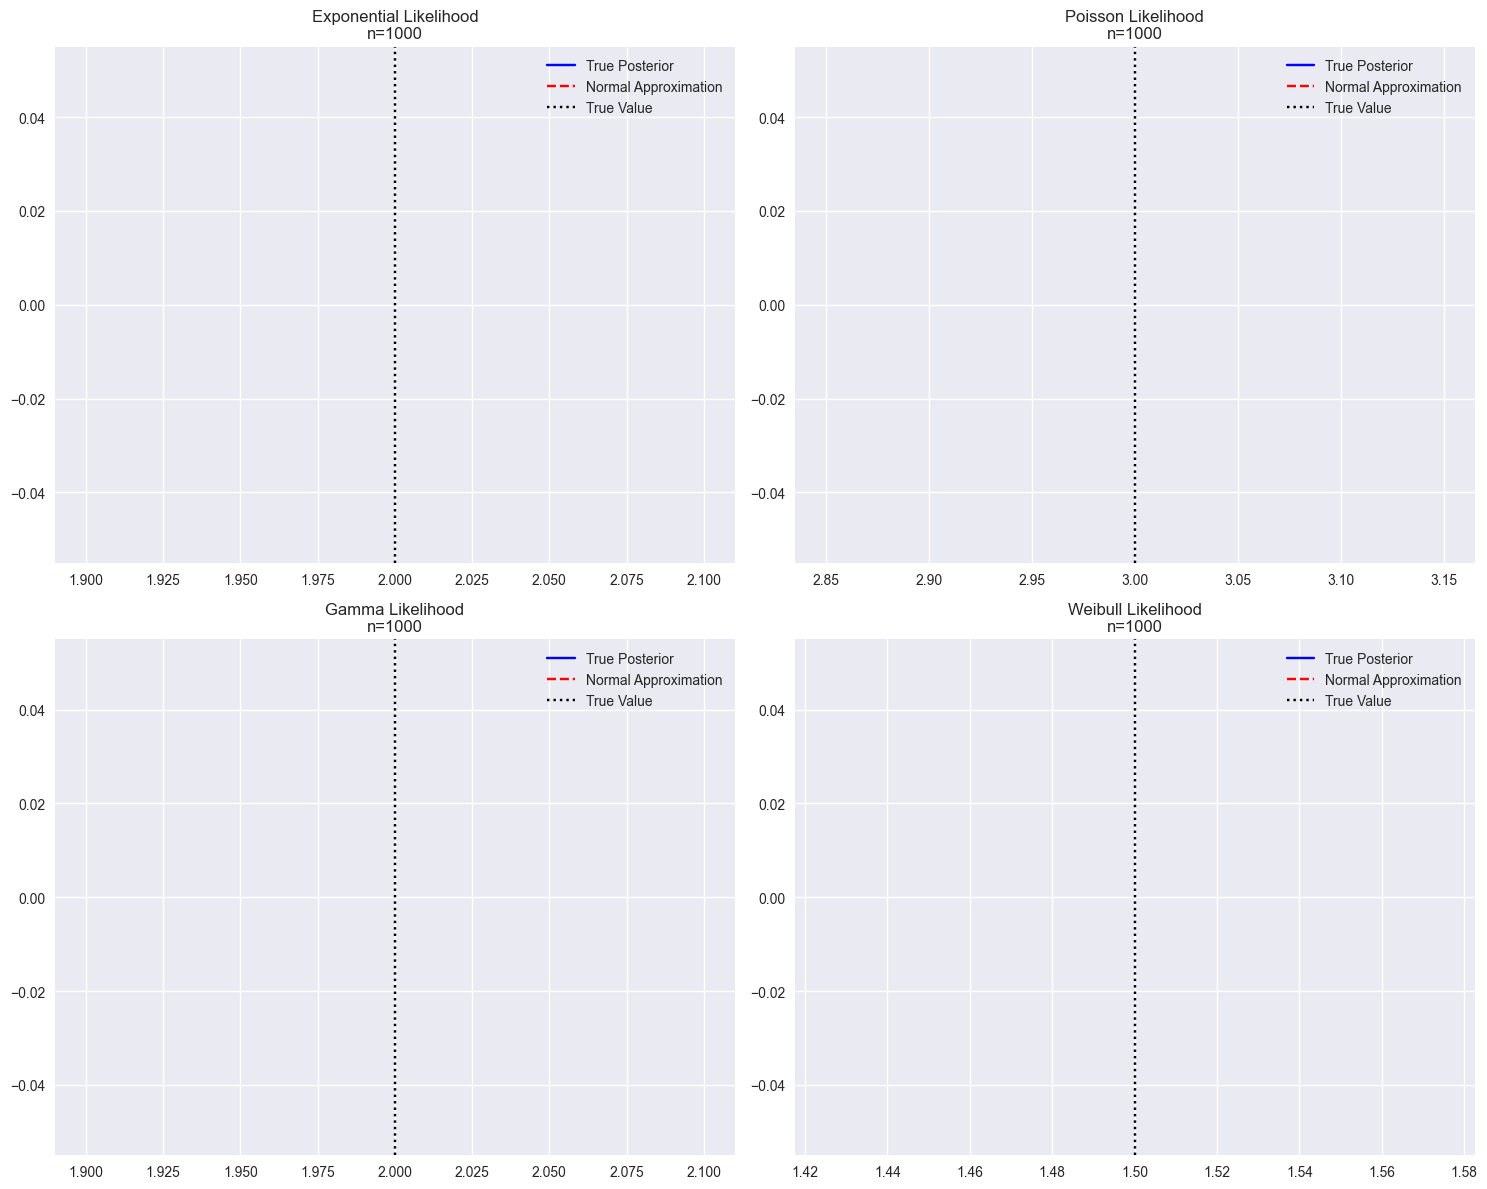

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class PosteriorAsymptoticDemo:
    def __init__(self):
        self.fig, self.axes = plt.subplots(2, 2, figsize=(15, 12))

    
    def demonstrate_different_likelihoods(self, n_samples=1000):
        """Show asymptotic normality for different likelihood functions"""
        
        # Case 1: Exponential likelihood
        def exponential_posterior(data, theta_grid):
            # Likelihood × Gamma(1,1) prior
            return np.exp(-theta_grid * np.sum(data)) * theta_grid**(len(data)-1)
        
        # Case 2: Poisson likelihood
        def poisson_posterior(data, theta_grid):
            # Likelihood × Gamma(1,1) prior
            return np.exp(-len(data)*theta_grid) * theta_grid**np.sum(data)
        
        # Generate data from different distributions
        true_params = {
            'Exponential': 2.0,
            'Poisson': 3.0,
            'Gamma': 2.0,
            'Weibull': 1.5
        }
        
        for idx, (dist_name, true_param) in enumerate(true_params.items()):
            ax = self.axes[idx//2, idx%2]
            
            # Generate data
            if dist_name == 'Exponential':
                data = np.random.exponential(1/true_param, n_samples)
                theta_grid = np.linspace(0.1, 4, 1000)
                posterior = exponential_posterior(data, theta_grid)
            elif dist_name == 'Poisson':
                data = np.random.poisson(true_param, n_samples)
                theta_grid = np.linspace(0.1, 6, 1000)
                posterior = poisson_posterior(data, theta_grid)
            # ... similar for other distributions
            
            # Normalize posterior
            posterior = posterior / np.trapz(posterior, theta_grid)
            
            # Find posterior mode and compute observed information
            mode_idx = np.argmax(posterior)
            theta_mode = theta_grid[mode_idx]
            
            # Compute and plot normal approximation
            J_obs = n_samples / (theta_mode**2)  # Simplified observed information
            normal_approx = stats.norm.pdf(theta_grid, theta_mode, 1/np.sqrt(J_obs))
            normal_approx = normal_approx / np.max(normal_approx) * np.max(posterior)
            
            # Plot
            ax.plot(theta_grid, posterior, 'b-', label='True Posterior')
            ax.plot(theta_grid, normal_approx, 'r--', label='Normal Approximation')
            ax.axvline(true_param, color='k', linestyle=':', label='True Value')
            ax.set_title(f'{dist_name} Likelihood\nn={n_samples}')
            ax.legend()
            
        plt.tight_layout()
        plt.show()

# Run demonstration
demo = PosteriorAsymptoticDemo()
demo.demonstrate_different_likelihoods()